# LogReg 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, log_loss, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
#test

In [2]:
df = pd.read_pickle('datenVorbUndersampling.pkl')

In [3]:
df

,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue,Geschlecht,Alter,Interesse
0,1,32.0,1,1,0,2630.0,156.0,145,0,32,0.0
1,1,15.0,0,1,1,23099.0,26.0,183,0,51,1.0
2,1,8.0,0,1,1,39170.0,25.0,32,0,57,1.0
3,1,38.0,0,0,1,26467.0,156.0,212,1,27,1.0
4,1,15.0,0,1,1,50093.0,154.0,78,1,31,1.0
...,...,...,...,...,...,...,...,...,...,...,...
93415,1,23.0,0,1,1,22138.0,26.0,157,0,35,1.0
93416,1,28.0,0,2,1,26235.0,26.0,195,0,62,1.0
93417,1,26.0,0,0,1,25405.0,152.0,181,0,24,0.0
93418,1,28.0,0,1,1,49430.0,124.0,119,1,42,1.0


## Modell Training

In [4]:
X = df.drop('Interesse', axis=1)
y = df['Interesse']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
pipeline = Pipeline([('scaler',StandardScaler()),('logreg', LogisticRegression(solver='liblinear',penalty='l1',max_iter=100))]) #unterschiedliche scalen führen zu schlechter konvergenz ->viel itterationen
model = LogisticRegression(solver='liblinear',penalty='l1', max_iter= 100000) #l1 weil manche features keinen großen einfluss haben 
model.fit(X_train, y_train)
pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(penalty='l1', solver='liblinear'))])

## Cross Validation und Test 

In [5]:
scores = cross_val_score(pipeline, X_train, y_train, cv=5)

print(f'Trainingsatz Cossval: {scores}')
print(f'Druchschnitt:  {scores.mean()}')

Trainingsatz Cossval: [0.79203303 0.78775136 0.78148176 0.78247572 0.78345313]
Druchschnitt:  0.7854390007359491


In [6]:
y_pred = model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))
print(f"Train Accuracy: {model.score(X_train, y_train):.4f}")

Accuracy: 0.7870905587668593
              precision    recall  f1-score   support

         0.0       0.96      0.60      0.74     13999
         1.0       0.71      0.98      0.82     14027

    accuracy                           0.79     28026
   macro avg       0.84      0.79      0.78     28026
weighted avg       0.84      0.79      0.78     28026

Train Accuracy: 0.7852


In [7]:
y_pred = pipeline.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))
print(f"Train Accuracy: {pipeline.score(X_train, y_train):.4f}")

Accuracy: 0.7871976022265039
              precision    recall  f1-score   support

         0.0       0.96      0.60      0.74     13999
         1.0       0.71      0.98      0.82     14027

    accuracy                           0.79     28026
   macro avg       0.84      0.79      0.78     28026
weighted avg       0.84      0.79      0.78     28026

Train Accuracy: 0.7855


## Auswertungen

In [8]:
# Vorhersagewahrscheinlichkeiten für die Klasse 1 (positive Klasse)
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
# Log Loss
logloss = log_loss(y_test, y_pred_prob)

# AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_pred_prob)
print(f"Log Loss: {logloss:.4f}")
print(f"AUC: {auc:.4f}")


Log Loss: 0.4386
AUC: 0.8344


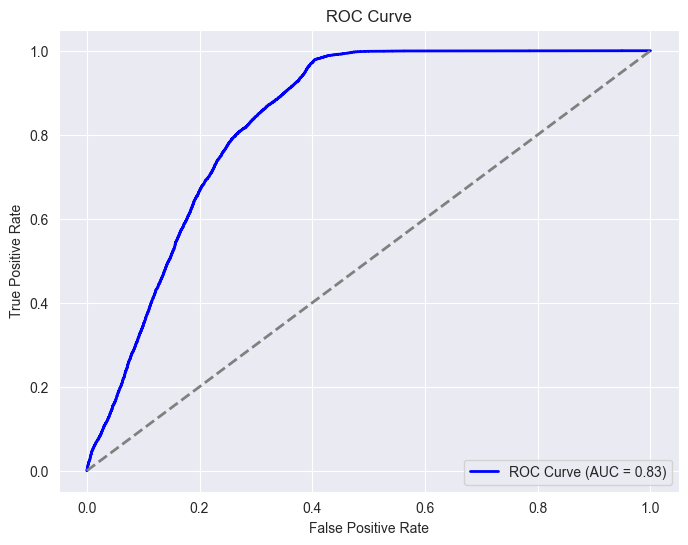

In [9]:

# Berechnung der FPR und TPR für verschiedene Schwellenwerte
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)


# Plotten der ROC-Kurve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonale Linie für zufällige Klassifikation
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Feature Einfluss

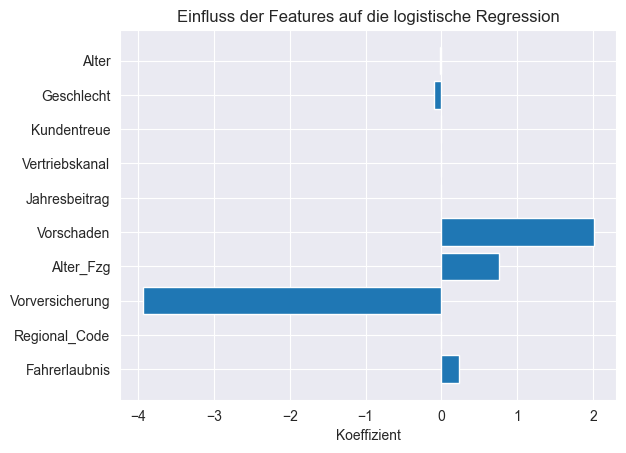

In [10]:
coefficients = model.coef_[0]
feature_names = X.columns
# Visualisierung
plt.barh(feature_names, coefficients)
plt.xlabel('Koeffizient')
plt.title('Einfluss der Features auf die logistische Regression')
plt.show()

## Weiteres Vorgehen 

### da eine Logistische regression in der Regel nicht so sehr auf die Hyperparameter reagiert wie komplexere modelle
### Es sollte viel Zeit in das Feature-engeneering gesteckt werden um bessere Einflüsse zu erstellen, PCA auf alles oder zumindest stark korrelierende Features wäre eine möglichkeit, da die Komplexitöt des models veringert werden würde 
### Da das Gradient Bossing model vielversprecheneder ist, sollte der augenmerk darauf gelegt werden 